In [26]:
#Refer github codes/tensorflow documentation for clear view for DCGAN


import warnings
warnings.filterwarnings('ignore')


import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


In [2]:
(x_train, y_train), _ = cifar10.load_data()

#normalize the data
x_train = x_train.astype('float32')/255.0

In [3]:
def plot_images(X):
    plt.figure(1)
    z = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(X[z])
            z = z + 1

    plt.show()

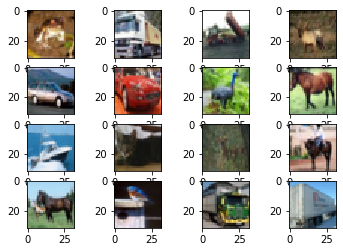

In [4]:
plot_images(x_train[:17])

In [5]:
#initialize weights by drawing from a truncated normal distribution
kernel_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)

In [6]:
def discriminator(input_images, reuse=False, is_training=False, alpha=0.1):
    
    with tf.variable_scope('discriminator', reuse= reuse):
        

        #first convolutional layer with leaky relu activations
        layer1 = tf.layers.conv2d(input_images, 
                                  filters=64, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv1')

        layer1 = tf.nn.leaky_relu(layer1, alpha=0.2, name='leaky_relu1')
    
        #second convolutional layer with batch normalization and leaky relu activations
        layer2 = tf.layers.conv2d(layer1, 
                                  filters=128, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        
        layer2 = tf.nn.leaky_relu(layer2, alpha=0.2, name='leaky_relu2')

        
        #third convolutional layer with batch normalization followed by leaky relu activations
        layer3 = tf.layers.conv2d(layer2, 
                                 filters=256, 
                                 kernel_size=5, 
                                 strides=1,
                                 padding='same',
                                 name='conv3')
        layer3 = tf.layers.batch_normalization(layer3, training=is_training, name='batch_normalization3')
        layer3 = tf.nn.leaky_relu(layer3, alpha=0.1, name='leaky_relu3')
        
        
        #flatten the output of the final convolutional layer
        layer3 = tf.reshape(layer3, (-1, layer3.shape[1]*layer3.shape[2]*layer3.shape[3]))
        
        
        #define the fully connected layer and return the logits
        logits= tf.layers.dense(layer3, 1)
        
        output = tf.sigmoid(logits)
        
        return logits


In [7]:
def generator(z, z_dim, batch_size, is_training=False, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        #input
        input_to_conv = tf.layers.dense(z, 8*8*128)
        #print("shaa",input_to_conv.shape)
        
        #convert the shape of the input and apply batch normalization followed by a relu activations
        layer1 = tf.reshape(input_to_conv, (-1, 8, 8, 128))
        #print("shaa",layer1.shape)
        layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='batch_normalization1')
        layer1 = tf.nn.relu(layer1, name='relu1')
        
        #define the second layer which is the transpose convolution with batch normalization and relu activation
        layer2 = tf.layers.conv2d_transpose(layer1, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        layer2 = tf.nn.relu(layer2, name='relu2')
        
        #define the third layer with transpose convolution operation with a batch norm and relu activation
        layer3 = tf.layers.conv2d_transpose(layer2, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution3')
        layer3 = tf.layers.batch_normalization(layer3,training=is_training, name='batch_normalization3')
        layer3 = tf.nn.relu(layer3, name='relu3')
        
        #fourth layer  with convolutional transpose operation with a batch norm and relu activation
        layer4 = tf.layers.conv2d_transpose(layer3, filters=256, kernel_size=5, strides= 1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution4')
        layer4 = tf.layers.batch_normalization(layer4,training=is_training, name='batch_normalization4')
        layer4 = tf.nn.relu(layer4, name='relu4')
        
        
        #in the final layer, we don't apply batch normalization and instead of relu we use tanh activation
        layer5 = tf.layers.conv2d_transpose(layer4, filters=3, kernel_size=7, strides=1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution5')
           
        
        logits = tf.tanh(layer5, name='tanh')
        
        return logits

In [8]:
image_hight = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]


x = tf.placeholder(tf.float32, shape= (None, image_hight,image_width ,image_channels), name="d_input")

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [10]:
learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
is_training = tf.placeholder(tf.bool, [], name='is_training')

In [11]:
batch_size = 100
z_dim = 100

In [12]:
z = tf.random_normal([batch_size, z_dim], mean=0.0, stddev=1.0, name='z')

In [13]:
z.shape

TensorShape([Dimension(100), Dimension(100)])

In [14]:
fake_x = generator(z, z_dim, batch_size, is_training=is_training)

In [15]:
D_logit_real = discriminator(x, reuse=False, is_training=is_training)

In [16]:
D_logit_fake = discriminator(fake_x, reuse=True,  is_training=is_training)

In [17]:
#Discriminator loss function first term
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_real),
                                                                     logits=D_logit_real))


In [18]:
#Discriminator loss function second term
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_logit_fake),
                                                                     logits=D_logit_fake))

In [19]:
D_loss = D_loss_real + D_loss_fake

In [20]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_fake),
                                                                logits=D_logit_fake))


In [21]:
training_vars = tf.trainable_variables()

theta_D = [var for var in training_vars if var.name.startswith('discriminator')]
theta_G = [var for var in training_vars if var.name.startswith('generator')]

In [22]:
d_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=theta_D)
g_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)


In [23]:
num_batches = int(x_train.shape[0] / batch_size)
steps = 0
num_epcohs = 500
lr = 0.00002


In [24]:
def generate_new_samples(session, n_images, z_dim):
    
    #randomly sample noise from the normal distribution
    z = tf.random_normal([1, z_dim], mean=0.0, stddev=1.0)

    is_training = tf.placeholder(tf.bool, [], name='training_bool')     
    
    #generate a fake image
    samples = session.run(generator(z, z_dim, batch_size, is_training, reuse=True),feed_dict={is_training: True})
    
    img = (samples[0] * 255).astype(np.uint8)
    
    #return the fake image
    plt.imshow(img)
    plt.show()


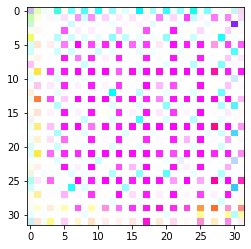

Epoch: 0, iteration: 89, Discriminator Loss:0.2985261082649231, Generator Loss: 2.9328386783599854


KeyboardInterrupt: 

In [25]:
with tf.Session() as session:
    
    #initialize all variables
    session.run(tf.global_variables_initializer())
    
    #for each epcohs
    for epoch in range(num_epcohs):
        
        #for number of batches
        for i in range(num_batches):
            
            #select start and end of the batch
            start = i * batch_size
            end = (i + 1) * batch_size
            
            #sample batch images
            batch_images = x_train[start:end]
            
            #train the discriminator after every two steps
            if(steps % 2 == 0):
                
                #train the discriminator
                _, discriminator_loss = session.run([d_optimizer,D_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
               
            
            #train the generator and discriminator
            _, generator_loss = session.run([g_optimizer,G_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
            _, discriminator_loss = session.run([d_optimizer,D_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
            display.clear_output(wait=True)  
            
            #generate new image
            generate_new_samples(session, 1, z_dim)
            print("Epoch: {}, iteration: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,i,discriminator_loss,generator_loss))
            

            steps += 1